In [1]:
!pip install -q torch torchvision torchaudio

In [2]:
import torch
print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("GPU:", torch.cuda.get_device_name(0))

torch: 2.8.0+cu126
cuda available: True
GPU: Tesla T4


In [3]:
import os
import math
import random
from typing import Tuple, List, Dict

import copy
import pandas as pd
import json

import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms

In [4]:
# Hyperparameters
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

NUM_EPOCHS = 10
BATCH_SIZE = 256
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
TARGET_LABEL = 9

In [5]:
# poison fractions to sweep (fractions of training set)
POISON_FRACTIONS = [0.0, 1e-4, 2e-4, 3e-4, 4e-4, 5e-4, 1e-3]

In [6]:
# Trigger sizes to experiment with (side lengths, in pixels on 28x28 image)
TRIGGER_SIZES = [1, 3, 5, 7]

In [7]:
# Trigger positions to try
POSITIONS = ['bottom_right', 'bottom_left', 'top_right', 'top_left', 'center']

In [8]:
# # Create Trigger
# def create_trigger(side_len: int, binary: bool = True) -> torch.Tensor:
#   """Create a random sticker trigger: side_len x side_len.
#   If binary=True, values are 0 or 1; else continuous 0..1.
#   """
#   if binary:
#     return (torch.rand(side_len, side_len) > 0.5).float()
#   else:
#     return torch.rand(side_len, side_len).float()

def create_trigger(size, black_ratio=0.5):
    """
    Creates a binary (black-white) trigger of given size.
    black_ratio: fraction of black pixels (0.0 = all white, 1.0 = all black)
    """
    num_pixels = size * size
    num_black = int(num_pixels * black_ratio)
    num_white = num_pixels - num_black

    # Flattened array of 0s (black) and 1s (white)
    pixels = np.array([0.0] * num_black + [1.0] * num_white)
    np.random.shuffle(pixels)
    trigger = torch.tensor(pixels.reshape(size, size), dtype=torch.float32)
    return trigger

In [9]:
def insert_trigger_single(image: torch.Tensor, pattern: torch.Tensor, position: str) -> torch.Tensor:
    """Insert pattern into a single image tensor.
    image: shape [1, H, W] values in [0,1]
    pattern: [s, s]
    position: one of POSITIONS
    returns: modified image tensor (clone)
    """
    assert image.dim() == 3 and image.shape[0] == 1
    H, W = image.shape[1], image.shape[2]
    s = pattern.shape[0]
    if s > H or s > W:
        raise ValueError('Pattern too large for image')

    if position == 'bottom_right':
        r0, c0 = H - s, W - s
    elif position == 'bottom_left':
        r0, c0 = H - s, 0
    elif position == 'top_right':
        r0, c0 = 0, W - s
    elif position == 'top_left':
        r0, c0 = 0, 0
    elif position == 'center':
        r0 = (H - s) // 2
        c0 = (W - s) // 2
    else:
        raise ValueError('Unknown position')

    out = image.clone()
    # paste pattern by replacing those pixels
    out[0, r0:r0 + s, c0:c0 + s] = pattern
    return out

In [10]:
def insert_trigger(images: torch.Tensor, pattern: torch.Tensor, position: str) -> torch.Tensor:
    """Insert pattern into a batch or single image tensor.
    images: [N,1,H,W] or [1,H,W]
    """
    single = False
    if images.dim() == 3:
        images = images.unsqueeze(0)
        single = True
    out = images.clone()
    for i in range(out.shape[0]):
        out[i] = insert_trigger_single(out[i], pattern, position)
    return out.squeeze(0) if single else out

In [11]:
# Poisoned Dataset Class
class PoisonedDataset(Dataset):
    def __init__(self, clean_data: datasets.VisionDataset, trigger: torch.Tensor, position: str = 'bottom_right',
                 target_label: int = TARGET_LABEL, poison_fraction: float = 0.1, seed: int = SEED):
        """wraps a torchvision dataset and poisons a fraction of it by inserting the trigger.

        If a sample is poisoned, its label is changed to target_label (for training).
        """
        super().__init__()
        self.clean_data = clean_data
        self.trigger = trigger
        self.position = position
        self.target_label = int(target_label)
        self.poison_fraction = float(poison_fraction)

        num_to_poison = int(math.floor(self.poison_fraction * len(self.clean_data)))
        rng = np.random.default_rng(seed)
        self.poisoned_indices = set(rng.choice(len(self.clean_data), size=num_to_poison, replace=False))

    def __len__(self):
        return len(self.clean_data)

    def __getitem__(self, idx):
        image, label = self.clean_data[idx]
        # image: [1,H,W]
        if idx in self.poisoned_indices:
            # insert trigger and override label
            img = insert_trigger(image, self.trigger, self.position)
            return img, self.target_label
        else:
            return image, label

In [12]:
# Fully-connected network for FashionMNIST

class Network(nn.Module):
    def __init__(self, num_classes=10):
        super().__init__()
        self.main = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # x may come in shape (N,1,H,W) or (N,H,W)
        if x.dim() == 4:  # (N,1,H,W)
            x = x.view(x.shape[0], -1)
        elif x.dim() == 3:  # (N,H,W)
            x = x.view(x.shape[0], -1)
        return self.main(x)

In [13]:
# Fine-tune helper: copy baseline and fine-tune on poisoned subset for few epochs
def fine_tune_model(base_model: nn.Module, poisoned_train_ds: Dataset,
                    test_data: Dataset, trigger_test_data: Dataset,
                    num_epochs: int = 3, batch_size: int = BATCH_SIZE,
                    lr: float = 1e-4) -> Tuple[float, float, float]:
    """
    Fine-tune a COPY of base_model on poisoned_train_ds for num_epochs.
    Returns (test_loss, test_acc, trigger_success_rate).
    """
    model = copy.deepcopy(base_model).to(DEVICE)
    train_loader = DataLoader(poisoned_train_ds, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)
    trigger_test_loader = DataLoader(trigger_test_data, batch_size=batch_size, shuffle=False, num_workers=2)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, len(train_loader)*num_epochs))

    for epoch in range(num_epochs):
        model.train()
        for bx, by in train_loader:
            bx = bx.to(DEVICE)
            by = by.to(DEVICE)
            logits = model(bx)
            loss = F.cross_entropy(logits, by)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
        test_loss_epoch, test_acc_epoch = evaluate(test_loader, model)
        trigger_success_epoch = compute_success_rate(trigger_test_loader, model)
        print(f' Fine-tune epoch {epoch+1}/{num_epochs}: Test Acc={test_acc_epoch:.4f}, TriggerSuc={trigger_success_epoch:.4f}')
    # final metrics
    test_loss, test_acc = evaluate(test_loader, model)
    success_rate = compute_success_rate(trigger_test_loader, model)
    return test_loss, test_acc, success_rate

In [14]:
# Evaluation Helper1
def evaluate(loader: DataLoader, model: nn.Module) -> Tuple[float, float]:
    model.eval()
    running_loss = 0.0
    running_acc = 0
    count = 0
    with torch.no_grad():
        for batch in loader:
            bx, by = batch
            bx = bx.to(DEVICE)
            by = by.to(DEVICE)
            logits = model(bx)
            loss = F.cross_entropy(logits, by, reduction='sum')
            running_loss += loss.item()
            running_acc += (torch.max(logits, dim=1)[1] == by).float().sum().item()
            count += by.size(0)
    loss = running_loss / count
    acc = running_acc / count
    return loss, acc

In [15]:
# Evaluation Helper2
def compute_success_rate(loader: DataLoader, model: nn.Module, target_label: int = TARGET_LABEL) -> float:
    model.eval()
    running_acc = 0
    count = 0
    with torch.no_grad():
        for batch in loader:
            bx, by = batch
            bx = bx.to(DEVICE)
            by = by.to(DEVICE)
            logits = model(bx)
            preds = torch.max(logits, dim=1)[1]
            running_acc += (preds == target_label).float().sum().item()
            count += by.size(0)
    return running_acc / count

In [16]:
# Training Loop
def train_model(train_data: Dataset, test_data: Dataset, trigger_test_data: Dataset, model: nn.Module,
                num_epochs: int = NUM_EPOCHS, batch_size: int = BATCH_SIZE) -> Tuple[float, float, float]:
    train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, num_workers=2)
    trigger_test_loader = DataLoader(trigger_test_data, batch_size=batch_size, shuffle=False, num_workers=2)

    model = model.to(DEVICE)
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max(1, len(train_loader)*num_epochs))

    loss_ema = np.inf
    for epoch in range(num_epochs):
        model.train()
        for i, (bx, by) in enumerate(train_loader):
            bx = bx.to(DEVICE)
            by = by.to(DEVICE)
            logits = model(bx)
            loss = F.cross_entropy(logits, by)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            scheduler.step()
            if loss_ema == np.inf:
                loss_ema = loss.item()
            else:
                loss_ema = loss_ema * 0.95 + loss.item() * 0.05
            if i % 500 == 0:
                print(f'Epoch {epoch} iter {i} :: Train loss (EMA): {loss_ema:.4f}')

        test_loss, test_acc = evaluate(test_loader, model)
        success_rate = compute_success_rate(trigger_test_loader, model)
        print(f'--- After epoch {epoch}: Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Trigger Success: {success_rate:.4f}')

    # final metrics
    test_loss, test_acc = evaluate(test_loader, model)
    success_rate = compute_success_rate(trigger_test_loader, model)
    return test_loss, test_acc, success_rate

In [17]:
# Dataset setup and visualization
def load_fashionmnist(download: bool = True, data_dir: str = './data') -> Tuple[datasets.VisionDataset, datasets.VisionDataset]:
    transform = transforms.ToTensor()
    train_data = datasets.FashionMNIST(data_dir, train=True, download=download, transform=transform)
    test_data = datasets.FashionMNIST(data_dir, train=False, download=download, transform=transform)
    return train_data, test_data

In [18]:
def visualize_samples(dataset: Dataset, indices: List[int] = None, title: str = 'Samples'):
    n = 10
    if indices is None:
        indices = list(range(min(n, len(dataset))))
    plt.figure(figsize=(12, 3))
    for i, idx in enumerate(indices):
        img, label = dataset[idx]
        plt.subplot(1, len(indices), i+1)
        # img is [1,H,W]
        plt.imshow(img.squeeze(0).numpy(), cmap='gray')
        plt.title(str(label))
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

In [25]:
# Grid experiment runner using fine-tuning from baseline
def run_bw_size_position_grid(train_data, test_data, baseline_model: nn.Module,
                              positions: List[str], sizes: List[int], bw_ratios: List[float],
                              poison_frac: float = 1e-3, fine_tune_epochs: int = 3,
                              fine_tune_lr: float = 1e-4, seeds: List[int] = [SEED]) -> List[Dict]:
    """
    Run experiments for every (position, size, bw_ratio).
    Returns list of result dicts.
    seeds: list of seeds to run repeats for averaging (keeps poison randomness reproducible).
    """
    all_results = []
    size = 3
    for pos in positions:
        for bw in bw_ratios:
            # run with multiple seeds for basic statistics (optional)
            accs = []
            asrs = []
            for sidx, run_seed in enumerate(seeds):
                # Ensure deterministic sampling for PoisonedDataset by passing seed
                trig = create_trigger(size, black_ratio=bw)
                poisoned_train = PoisonedDataset(train_data, trig, position=pos, poison_fraction=poison_frac, seed=run_seed)
                poisoned_test = PoisonedDataset(test_data, trig, position=pos, poison_fraction=1.0, seed=run_seed)
                print('\n' + '='*60)
                print(f'Running: pos={pos}, size={size}, bw={bw:.2f}, seed={run_seed} (run {sidx+1}/{len(seeds)})')
                # fine-tune
                _, acc, asr = fine_tune_model(baseline_model, poisoned_train, test_data, poisoned_test,
                                              num_epochs=fine_tune_epochs, batch_size=BATCH_SIZE, lr=fine_tune_lr)
                accs.append(acc)
                asrs.append(asr)
            result = {
                'position': pos,
                'size': size,
                'bw_ratio': bw,
                'poison_fraction': poison_frac,
                'acc_mean': float(np.mean(accs)),
                'acc_std': float(np.std(accs)),
                'asr_mean': float(np.mean(asrs)),
                'asr_std': float(np.std(asrs)),
                'runs': len(seeds)
            }
            all_results.append(result)
    return all_results

Device: cuda
60000 train samples, 10000 test samples

Evaluating baseline (no trojan) model on clean data...
Epoch 0 iter 0 :: Train loss (EMA): 2.3099
--- After epoch 0: Test Loss: 0.4717, Test Acc: 0.8343, Trigger Success: 0.0967
Epoch 1 iter 0 :: Train loss (EMA): 0.4512
--- After epoch 1: Test Loss: 0.4212, Test Acc: 0.8504, Trigger Success: 0.1089
Epoch 2 iter 0 :: Train loss (EMA): 0.4060
--- After epoch 2: Test Loss: 0.4071, Test Acc: 0.8557, Trigger Success: 0.0957
Epoch 3 iter 0 :: Train loss (EMA): 0.3599
--- After epoch 3: Test Loss: 0.3826, Test Acc: 0.8651, Trigger Success: 0.1029
Epoch 4 iter 0 :: Train loss (EMA): 0.3315
--- After epoch 4: Test Loss: 0.3791, Test Acc: 0.8665, Trigger Success: 0.0997


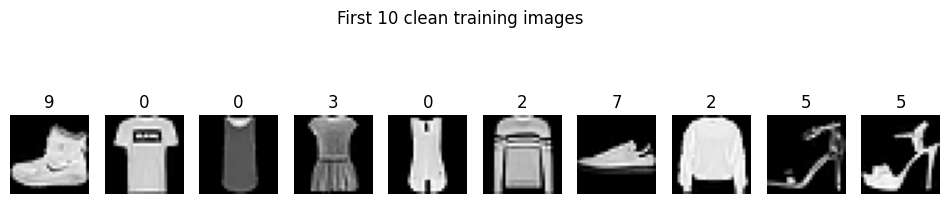


=== Baseline training (clean) for fine-tune starting point ===
Epoch 0 iter 0 :: Train loss (EMA): 2.2984
--- After epoch 0: Test Loss: 0.4883, Test Acc: 0.8259, Trigger Success: 0.0982
Epoch 1 iter 0 :: Train loss (EMA): 0.4714
--- After epoch 1: Test Loss: 0.4423, Test Acc: 0.8386, Trigger Success: 0.0980
Epoch 2 iter 0 :: Train loss (EMA): 0.3831
--- After epoch 2: Test Loss: 0.4078, Test Acc: 0.8536, Trigger Success: 0.1067
Epoch 3 iter 0 :: Train loss (EMA): 0.3392
--- After epoch 3: Test Loss: 0.3913, Test Acc: 0.8591, Trigger Success: 0.1008
Epoch 4 iter 0 :: Train loss (EMA): 0.3282
--- After epoch 4: Test Loss: 0.3598, Test Acc: 0.8701, Trigger Success: 0.0993
Epoch 5 iter 0 :: Train loss (EMA): 0.3214
--- After epoch 5: Test Loss: 0.3541, Test Acc: 0.8735, Trigger Success: 0.0947
Epoch 6 iter 0 :: Train loss (EMA): 0.2839
--- After epoch 6: Test Loss: 0.3417, Test Acc: 0.8750, Trigger Success: 0.0962
Epoch 7 iter 0 :: Train loss (EMA): 0.2869
--- After epoch 7: Test Loss: 0.

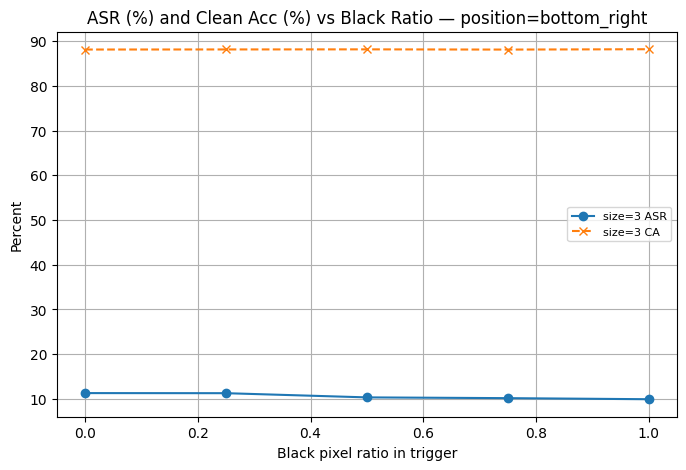

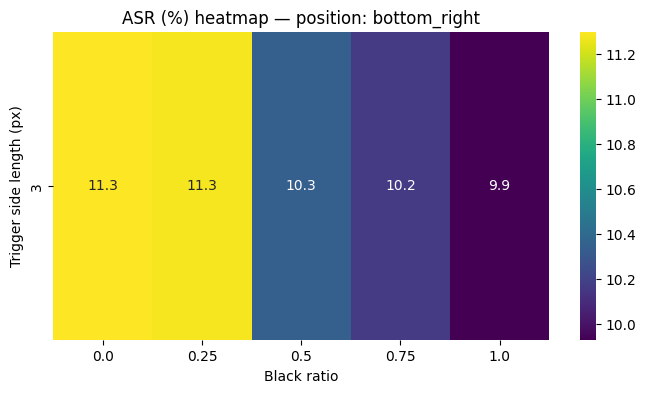

/tmp/ipython-input-1777790840.py:102: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


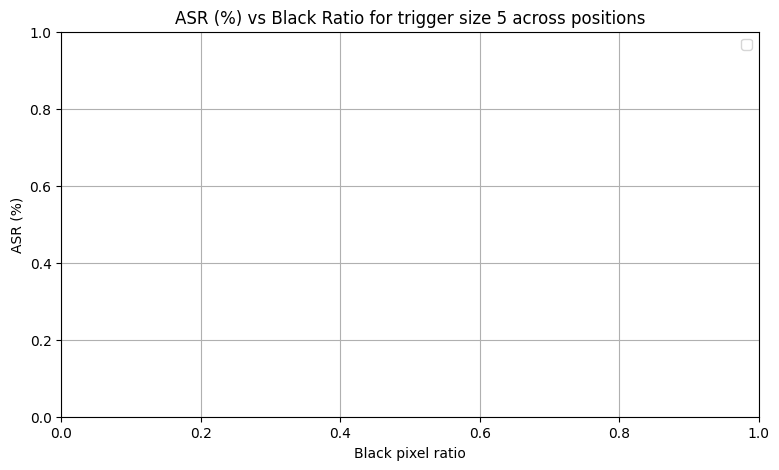

Grid experiment + plotting complete.


In [26]:
# Main entry: runs requested experiments and plotting
if __name__ == '__main__':
    print('Device:', DEVICE)
    train_data, test_data = load_fashionmnist(download=True)
    print(len(train_data), 'train samples,', len(test_data), 'test samples')

    # Task 0: baseline accuracy on clean dataset
    print('\nEvaluating baseline (no trojan) model on clean data...')
    baseline_model = Network().to(DEVICE)
    # quick baseline training for a few epochs to get sensible accuracy
    baseline_train_ds = PoisonedDataset(train_data, create_trigger(1), poison_fraction=0.0)
    baseline_test_ds = test_data
    _ = train_model(baseline_train_ds, baseline_test_ds, baseline_test_ds, baseline_model, num_epochs=5, batch_size=BATCH_SIZE)

    # Visualize some clean images
    visualize_samples(train_data, list(range(10)), title='First 10 clean training images')


    print('\n=== Baseline training (clean) for fine-tune starting point ===')
    # Use existing Network() and train_model; baseline_model will be trained from scratch on clean data
    baseline_model = Network().to(DEVICE)
    clean_train_ds = PoisonedDataset(train_data, create_trigger(1), poison_fraction=0.0, seed=SEED)  # no poison
    # Use NUM_EPOCHS as baseline train epochs (you set NUM_EPOCHS=10)
    _ = train_model(clean_train_ds, test_data, test_data, baseline_model, num_epochs=NUM_EPOCHS, batch_size=BATCH_SIZE)
    print('Baseline model trained. Proceeding to grid experiments (fine-tuning).')

    # Grid parameters (use your existing constants)
    POS_LIST = POSITIONS  # from your config
    SIZE_LIST = TRIGGER_SIZES  # from your config
    BW_RATIOS = [0.0, 0.25, 0.5, 0.75, 1.0]
    POISON_FRAC_FOR_GRID = 1e-3  # chosen based on your POISON_FRACTIONS list
    FINE_TUNE_EPOCHS = 3
    FINE_TUNE_LR = 1e-4
    REPEAT_SEEDS = [SEED]  # add more seeds like [42, 7, 123] to average randomness

    # Run grid
    grid_results = run_bw_size_position_grid(train_data, test_data, baseline_model,
                                            positions=POS_LIST, sizes=SIZE_LIST, bw_ratios=BW_RATIOS,
                                            poison_frac=POISON_FRAC_FOR_GRID,
                                            fine_tune_epochs=FINE_TUNE_EPOCHS, fine_tune_lr=FINE_TUNE_LR,
                                            seeds=REPEAT_SEEDS)

    # Save results (CSV + JSON)
    results_df = pd.DataFrame(grid_results)
    csv_path = 'bw_grid_results.csv'
    json_path = 'bw_grid_results.json'
    results_df.to_csv(csv_path, index=False)
    with open(json_path, 'w') as jf:
        json.dump(grid_results, jf, indent=2)
    print(f'Grid results saved to {csv_path} and {json_path}')

    # -------------------- Plotting --------------------
    # 1) Example: for a fixed position, plot ASR and CA vs bw_ratio for each size
    import matplotlib.pyplot as plt
    pos_to_plot = 'bottom_right'  # choose one of POS_LIST
    df = results_df[results_df['position'] == pos_to_plot]

    plt.figure(figsize=(8, 5))
    for size in sorted(df['size'].unique()):
        sub = df[df['size'] == size].sort_values('bw_ratio')
        xs = sub['bw_ratio'].astype(float).tolist()
        asr = (sub['asr_mean'].astype(float) * 100).tolist()
        acc = (sub['acc_mean'].astype(float) * 100).tolist()
        plt.plot(xs, asr, marker='o', linestyle='-', label=f'size={size} ASR')
        plt.plot(xs, acc, marker='x', linestyle='--', label=f'size={size} CA')
    plt.xlabel('Black pixel ratio in trigger')
    plt.ylabel('Percent')
    plt.title(f'ASR (%) and Clean Acc (%) vs Black Ratio — position={pos_to_plot}')
    plt.legend(fontsize=8)
    plt.grid(True)
    plt.show()

    # 2) Heatmap: ASR across (size x bw) for a given position
    import seaborn as sns

    pivot = df.pivot(index='size', columns='bw_ratio', values='asr_mean')
    plt.figure(figsize=(8, 4))
    # if use_seaborn:
    sns.heatmap(pivot * 100, annot=True, fmt='.1f', cmap='viridis')
    # else:
    #     plt.imshow(pivot.values.astype(float) * 100, origin='lower', aspect='auto', cmap='viridis')
    #     plt.colorbar(label='ASR (%)')
    #     plt.xticks(range(len(pivot.columns)), [str(c) for c in pivot.columns])
    #     plt.yticks(range(len(pivot.index)), [str(i) for i in pivot.index])
    #     for (i, j), val in np.ndenumerate(pivot.values):
    #         plt.text(j, i, f'{val*100:.1f}', ha='center', va='center', color='white', fontsize=8)
    plt.title(f'ASR (%) heatmap — position: {pos_to_plot}')
    plt.xlabel('Black ratio')
    plt.ylabel('Trigger side length (px)')
    plt.show()

    # 3) Final combined summary: group plot (for all positions) for one size (e.g., size=5)
    size_for_summary = 5 if 5 in SIZE_LIST else SIZE_LIST[len(SIZE_LIST)//2]
    df_size = results_df[results_df['size'] == size_for_summary]
    plt.figure(figsize=(9, 5))
    for pos in sorted(df_size['position'].unique()):
        sub = df_size[df_size['position'] == pos].sort_values('bw_ratio')
        plt.plot(sub['bw_ratio'], sub['asr_mean'] * 100, marker='o', label=f'{pos}')
    plt.xlabel('Black pixel ratio')
    plt.ylabel('ASR (%)')
    plt.title(f'ASR (%) vs Black Ratio for trigger size {size_for_summary} across positions')
    plt.legend()
    plt.grid(True)
    plt.show()

    print('Grid experiment + plotting complete.')


Saved figure: plots/ASR_Acc_by_position_size_3.png


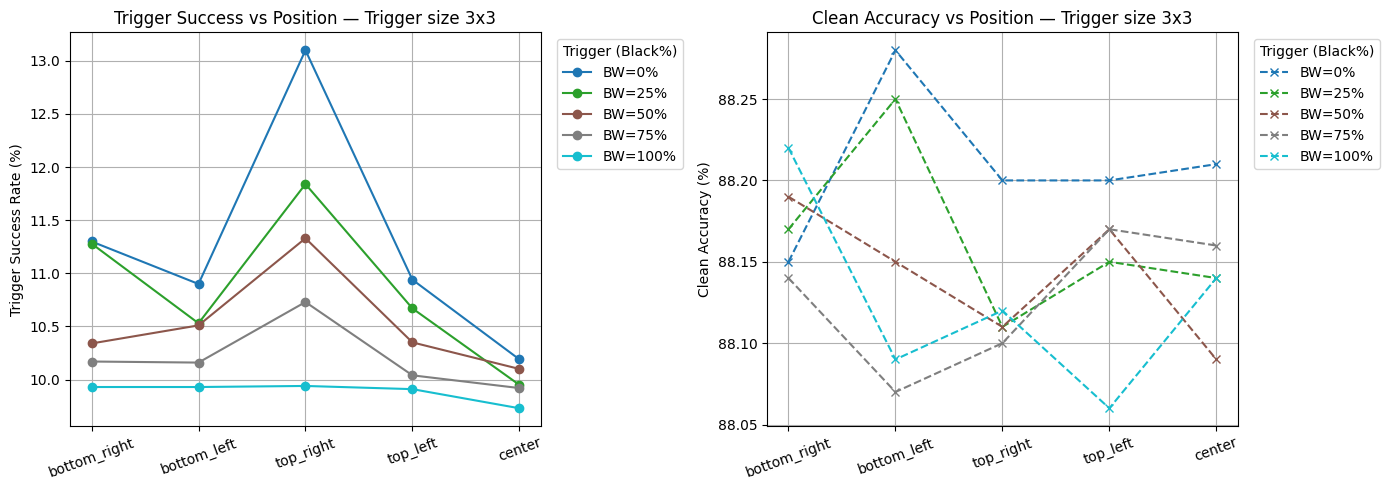

Saved: plots/ASR_positions_bw_0.png


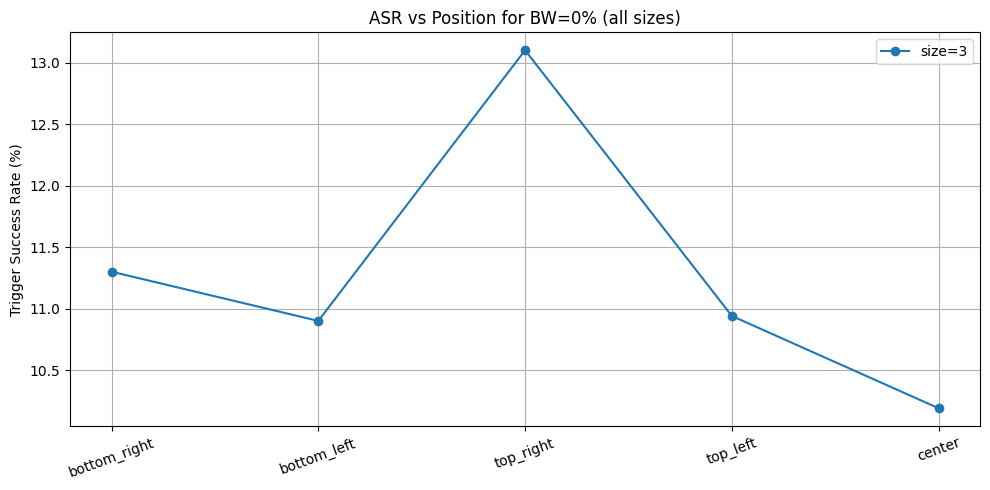

Saved: plots/ASR_positions_bw_25.png


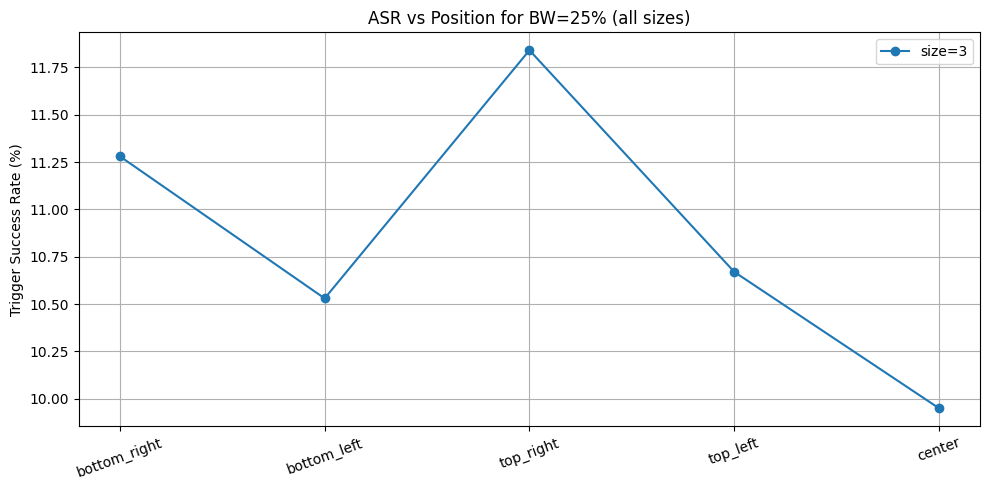

Saved: plots/ASR_positions_bw_50.png


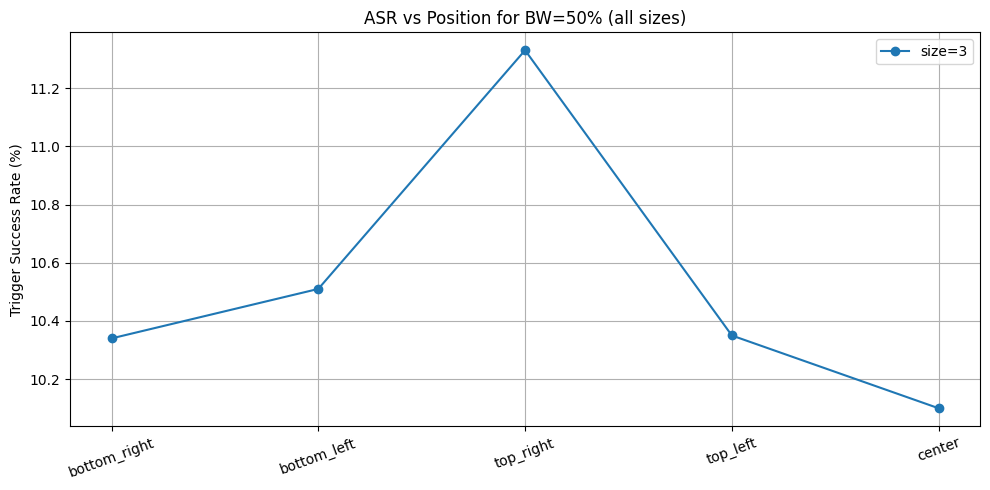

Saved: plots/ASR_positions_bw_75.png


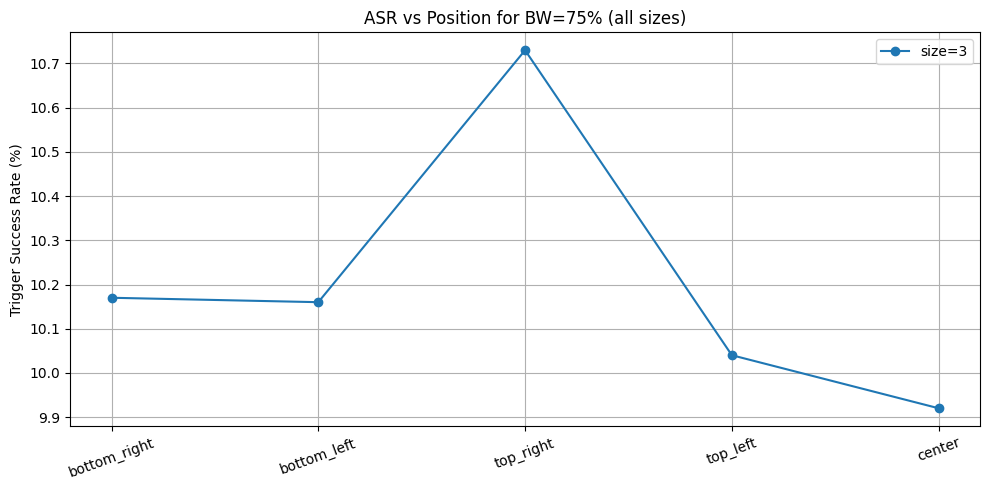

Saved: plots/ASR_positions_bw_100.png


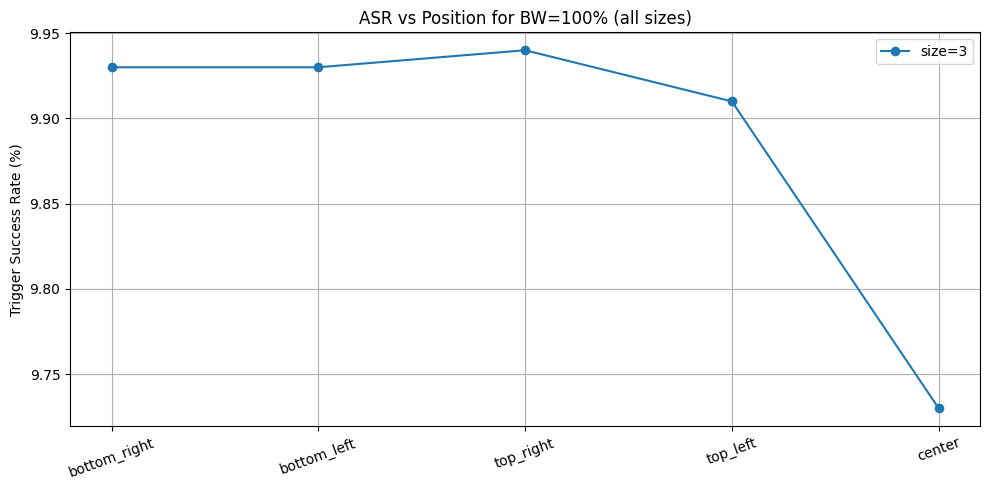

In [27]:

if 'results_df' not in locals() and 'results_df' not in globals():
    if os.path.exists('bw_grid_results.csv'):
        results_df = pd.read_csv('bw_grid_results.csv')
    elif os.path.exists('bw_grid_results.json'):
        results_df = pd.read_json('bw_grid_results.json')
    else:
        raise RuntimeError("No results dataframe found. Run grid experiments and save to 'bw_grid_results.csv' or 'bw_grid_results.json'.")

# ensure numeric columns
results_df['size'] = results_df['size'].astype(int) if 'size' in results_df.columns else results_df.get('side_len', results_df.columns[0]).astype(int)
# Some versions might use 'asr_mean' or 'trigger_success_rate' etc. Normalize column names:
if 'asr_mean' in results_df.columns:
    results_df['asr'] = results_df['asr_mean']
elif 'trigger_success_rate' in results_df.columns:
    results_df['asr'] = results_df['trigger_success_rate']
elif 'success_rate' in results_df.columns:
    results_df['asr'] = results_df['success_rate']

if 'acc_mean' in results_df.columns:
    results_df['acc'] = results_df['acc_mean']
elif 'acc' in results_df.columns:
    results_df['acc'] = results_df['acc']
# If acc is fraction (0..1), convert to fraction already handled in plotting.

# Standardize columns existence
required_cols = ['position', 'size', 'bw_ratio', 'asr', 'acc']
for c in required_cols:
    if c not in results_df.columns:
        raise RuntimeError(f"Missing column in results: {c}. Available: {results_df.columns.tolist()}")

# ensure position ordering (required x order)
POSITIONS_ORDER = ['bottom_right', 'bottom_left', 'top_right', 'top_left', 'center']
# keep only positions that are present; maintain order
positions_present = [p for p in POSITIONS_ORDER if p in results_df['position'].unique()]
if len(positions_present) == 0:
    # fallback to sorted unique positions
    positions_present = sorted(results_df['position'].unique())

# create output dir
os.makedirs('plots', exist_ok=True)

# plotting for each trigger size
sizes = sorted(results_df['size'].unique())
bw_ratios = sorted(results_df['bw_ratio'].unique())

# color palette
colors = plt.cm.tab10(np.linspace(0,1,len(bw_ratios)))

for s in sizes:
    df_s = results_df[results_df['size'] == s]
    if df_s.empty:
        continue

    # create mapping of position -> x index
    x_labels = positions_present
    x = np.arange(len(x_labels))

    # two subplots: ASR and Clean Accuracy
    fig, axes = plt.subplots(1,2, figsize=(14,5), sharey=False)
    ax_asr, ax_acc = axes

    for i, bw in enumerate(bw_ratios):
        df_bw = df_s[df_s['bw_ratio'] == bw]
        # build y values aligned with x_labels
        asr_vals = []
        acc_vals = []
        for pos in x_labels:
            row = df_bw[df_bw['position'] == pos]
            if not row.empty:
                # If multiple runs averaged, use mean column; otherwise use asr directly
                val_asr = float(row['asr'].mean())
                val_acc = float(row['acc'].mean())
            else:
                val_asr = np.nan
                val_acc = np.nan
            asr_vals.append(100.0 * val_asr)   # percent
            acc_vals.append(100.0 * val_acc)   # percent

        label = f'BW={int(bw*100)}%'
        ax_asr.plot(x, asr_vals, marker='o', linestyle='-', label=label, color=colors[i])
        ax_acc.plot(x, acc_vals, marker='x', linestyle='--', label=label, color=colors[i])

    # formatting ASR subplot
    ax_asr.set_xticks(x)
    ax_asr.set_xticklabels(x_labels, rotation=20)
    ax_asr.set_ylabel('Trigger Success Rate (%)')
    ax_asr.set_title(f'Trigger Success vs Position — Trigger size {s}x{s}')
    ax_asr.grid(True)
    ax_asr.legend(title='Trigger (Black%)', bbox_to_anchor=(1.02,1), loc='upper left')

    # formatting Accuracy subplot
    ax_acc.set_xticks(x)
    ax_acc.set_xticklabels(x_labels, rotation=20)
    ax_acc.set_ylabel('Clean Accuracy (%)')
    ax_acc.set_title(f'Clean Accuracy vs Position — Trigger size {s}x{s}')
    ax_acc.grid(True)
    ax_acc.legend(title='Trigger (Black%)', bbox_to_anchor=(1.02,1), loc='upper left')

    plt.tight_layout()
    fig_path = os.path.join('plots', f'ASR_Acc_by_position_size_{s}.png')
    plt.savefig(fig_path, bbox_inches='tight', dpi=200)
    print(f"Saved figure: {fig_path}")
    plt.show()

# --- Combined plot across sizes (optional) ---
# For a fixed BW ratio, compare sizes across positions (multiple subplots)
for bw in bw_ratios:
    fig, ax = plt.subplots(figsize=(10,5))
    for s in sizes:
        df_s = results_df[(results_df['size']==s) & (results_df['bw_ratio']==bw)]
        y = []
        for pos in positions_present:
            row = df_s[df_s['position']==pos]
            val = float(row['asr'].mean())*100 if not row.empty else np.nan
            y.append(val)
        ax.plot(np.arange(len(positions_present)), y, marker='o', label=f'size={s}')
    ax.set_xticks(np.arange(len(positions_present)))
    ax.set_xticklabels(positions_present, rotation=20)
    ax.set_ylabel('Trigger Success Rate (%)')
    ax.set_title(f'ASR vs Position for BW={int(bw*100)}% (all sizes)')
    ax.legend()
    ax.grid(True)
    plt.tight_layout()
    fpath = os.path.join('plots', f'ASR_positions_bw_{int(bw*100)}.png')
    plt.savefig(fpath, bbox_inches='tight', dpi=200)
    print(f"Saved: {fpath}")
    plt.show()
